In [13]:
# Import
import pandas as pd
import seaborn as sns

We would like to analyze how customers switch between sections of the supermarket.
So, let's calculate and visualize the probability of transitions from section A to B
by counting all observed transitions. E.g., if a customer was in the fruit section,
later in the spices section, and went back to fruit, we observe two transitions:
fruit → spices and spices → fruit .

The actual checkout is a special terminal state, from which customers cannot leave.
The specific goals we would like to achieve are:
1. Draw a state diagram
2. Display the transition probability matrix
3. Visualize the probabilities as a heat map

In [14]:
# Load in the previously created df and recreate datetimeindex
df = pd.read_csv("data/customer_behavior_allweeks.csv", sep=",")
df["timestamp"] = pd.to_datetime(df["timestamp"])

To get the movement pattern of each customer, we first can use pandas shift function
to shift the location one time point forward in time to give that previous location
relative to the time point where it was shifted to. Note that we need to do this on
a customer by customer basis, otherwise it is not accurate. The before of the first
entry of each customer is going to be NaN which is essentially when the customer
entered the store. So we just fill the value with that.
In the process, let's also change the time resolution so we can see customer behavior
on a minute-by-minute basis rather than just at location transition points.


In [15]:
df = df.set_index("timestamp")
df["before"] = df.groupby("customer_no")["location"].shift(1)
df_minutes = df.groupby("customer_no").resample("T").ffill().drop("customer_no", axis=1)
df_minutes = df_minutes.reset_index().set_index("timestamp")
df_minutes["before"] = df_minutes["before"].fillna(value="entrance")
# We can check customer transitions to see whether everything worked as intended:

df_minutes[
    (df_minutes["customer_no"] == "monday_1000") | (df_minutes["customer_no"] == "monday_1001")
]


,customer_no,location,week day,week day id,hour,minute,section_sequence,before
timestamp,,,,,,,,
2019-09-02 17:44:00,monday_1000,dairy,Monday,0,17,44,first,entrance
2019-09-02 17:45:00,monday_1000,dairy,Monday,0,17,44,first,entrance
2019-09-02 17:46:00,monday_1000,dairy,Monday,0,17,44,first,entrance
2019-09-02 17:47:00,monday_1000,dairy,Monday,0,17,44,first,entrance
2019-09-02 17:48:00,monday_1000,dairy,Monday,0,17,44,first,entrance
2019-09-02 17:49:00,monday_1000,dairy,Monday,0,17,44,first,entrance
2019-09-02 17:50:00,monday_1000,drinks,Monday,0,17,50,following,dairy
2019-09-02 17:51:00,monday_1000,checkout,Monday,0,17,51,following,drinks
2019-09-02 17:45:00,monday_1001,fruit,Monday,0,17,45,first,entrance


In [16]:
# or
df_minutes[
    (df_minutes["customer_no"] == "friday_1000") | (df_minutes["customer_no"] == "friday_1001")
]

,customer_no,location,week day,week day id,hour,minute,section_sequence,before
timestamp,,,,,,,,
2019-09-06 17:19:00,friday_1000,fruit,Friday,4,17,19,first,entrance
2019-09-06 17:20:00,friday_1000,checkout,Friday,4,17,20,following,fruit
2019-09-06 17:19:00,friday_1001,fruit,Friday,4,17,19,first,entrance
2019-09-06 17:20:00,friday_1001,fruit,Friday,4,17,19,first,entrance
2019-09-06 17:21:00,friday_1001,drinks,Friday,4,17,21,following,fruit
2019-09-06 17:22:00,friday_1001,drinks,Friday,4,17,21,following,fruit
2019-09-06 17:23:00,friday_1001,spices,Friday,4,17,23,following,drinks
2019-09-06 17:24:00,friday_1001,drinks,Friday,4,17,24,following,spices
2019-09-06 17:25:00,friday_1001,drinks,Friday,4,17,24,following,spices


Looks good. Let's visualize the transition probability matrix. For that we can use pandas crosstab
method. Note that the normalize parameter indicates on which axis to normalize on:


<AxesSubplot: xlabel='location', ylabel='before'>

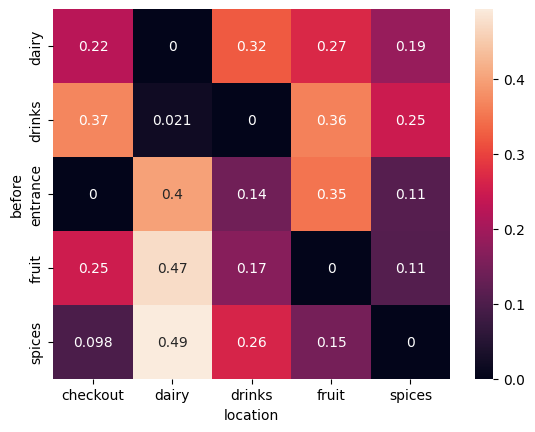

In [17]:
trans_prob_matrix = pd.crosstab(
    index=df_minutes["before"], columns=df_minutes["location"], normalize=0
)
sns.heatmap(trans_prob_matrix, annot=True)

Let's check whether our probabilities add up to 1 (which they must):

In [18]:
trans_prob_matrix.sum(axis=1)

before
dairy       1.0
drinks      1.0
entrance    1.0
fruit       1.0
spices      1.0
dtype: float64

... and indeed they do.
For our simulation we should store this matrix:

In [19]:
trans_prob_matrix.to_csv("data/transitional_probabilities.csv")